In [1]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from utils.utils import * 
from utils.data_loader import load_data
from utils.CNNs import *
from utils.CNN_datasets import WaveformDataset

In [2]:
final_clean_strained = load_data(db_level=0)
# Strain binary: 'C57B6' = 1, 'CBA/CaJ' = 0
final_clean_strained_70 = final_clean_strained[final_clean_strained['Level(dB)'] >= 70]
final_clean_strained_80 = final_clean_strained[final_clean_strained['Level(dB)'] == 80]

In [3]:
final_clean_strained_avg = final_clean_strained.groupby(['Subject', 'Frequency(kHz)', 'Level(dB)']).agg(
    {'Amplitude': 'mean',
     'vx': 'first',
     'SynapsesPerIHC': 'mean', 
     'IHCs': 'mean',
     'OrphansPerIHC': 'mean',
     'Waveform': 'first',
     'WaveI': 'first',
     'Peaks': 'first',
     'Troughs': 'first',
     'Strain': 'first',
     'Sex': 'first',
     'Group': 'first',
     'Noise': 'mean',
     'Time (str)': 'first',
     'Time (hrs)': 'first',
     'Strain (binary)': 'first',
    }).reset_index()

In [4]:
def split_by_mouse(data, 
                   split_on='Subject', 
                   stratify_on='Group', 
                   test_size=0.2, 
                   val_size=0.18, 
                   random_state=1,
                   return_idx=False):
    mice = data[[split_on, stratify_on]].drop_duplicates().set_index(split_on)

    train, test = train_test_split(mice.index, 
                                   test_size=test_size, 
                                   shuffle=True,
                                   stratify=mice[stratify_on], 
                                   random_state=random_state)

    train_indices = data[split_on].isin(train)
    test_indices = data[split_on].isin(test)

    train2, val = train_test_split(train,
                                   test_size=val_size,
                                   shuffle=True,
                                   stratify=mice.loc[train]['Group'],
                                   random_state=random_state)

    train2_indices = data[split_on].isin(train2)
    val_indices = data[split_on].isin(val)

    data['DataGroup'] = ''
    data.loc[train2_indices, 'DataGroup'] = 'Train'
    data.loc[val_indices, 'DataGroup'] = 'Validate'
    data.loc[test_indices, 'DataGroup'] = 'Test'
    if return_idx:
        return data, train_indices, train2_indices, val_indices, test_indices
    return data

In [5]:
use_dataset = final_clean_strained_avg[final_clean_strained_avg['Level(dB)']>=70] #final_clean_strained_avg

use_dataset = split_by_mouse(use_dataset)

train_set = use_dataset[use_dataset['DataGroup'] == 'Train']
val_set = use_dataset[use_dataset['DataGroup'] == 'Validate']
test_set = use_dataset[use_dataset['DataGroup'] == 'Test']

test_results = use_dataset[use_dataset['DataGroup'] == 'Test'].copy()
use_dataset['DataGroup'].value_counts()

DataGroup
Train       870
Test        264
Validate    206
Name: count, dtype: int64

In [6]:
class WaveformDatasetWithFreq(Dataset):
    def __init__(self, df, data='waveform'):
        self.df = df
        self.data = data
        self.waveforms, self.targets, self.frequencies, self.strains = self.prepare_data(df)
    
    def prepare_data(self, df):
        waveforms = []
        targets = []
        frequencies = []
        strains = []
        
        for idx, row in df.iterrows():
            if self.data == 'waveform':
                orig_y = row['Waveform']
                waveform = self.preprocess_waveform(orig_y, 20)
            elif self.data == 'wavei':
                waveform = row['WaveI']
            
            waveforms.append(waveform)
            targets.append(row['SynapsesPerIHC']/20)
            frequencies.append(row['Frequency(kHz)']/45.2)
            strains.append(row['Strain (binary)'])

        return waveforms, targets, frequencies, strains

    def preprocess_waveform(self, waveform, time_scale):
        orig_y = waveform
        tenms = int((10/time_scale)*len(orig_y)) if time_scale > 10 else len(orig_y)
        return interpolate_and_smooth(orig_y[:tenms], 244)

    def __len__(self):
        return len(self.waveforms)
    
    def __getitem__(self, idx):
        waveform = self.waveforms[idx].copy()
        
        waveform_tensor = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0)
        target_tensor = torch.tensor(self.targets[idx], dtype=torch.float32)
        frequency_tensor = torch.tensor(self.frequencies[idx], dtype=torch.float32)
        strain_tensor = torch.tensor(self.strains[idx], dtype=torch.float32)
        return waveform_tensor, target_tensor, frequency_tensor, strain_tensor

class WaveICNNWithFrequency(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(WaveICNNWithFrequency, self).__init__()

        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)  # 30 -> 30
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)  # 30 -> 30
        
        self.pool = nn.MaxPool1d(2)  # 30 -> 15 -> 7 (with padding)
        self.dropout = nn.Dropout(dropout_rate)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        self.fc = nn.Sequential(
            nn.Linear(34, 16), #32 pooled features + frequency + strain
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(16, 1)
        )
        
    def forward(self, x, frequency, strain):
        x = F.relu(self.conv1(x))
        x = self.pool(x)  # (batch_size, 16, 15)
    
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # (batch_size, 32, 7)
        
        x = self.dropout(x)
        
        # Global pooling
        x = self.global_pool(x).squeeze(-1)  # (batch_size, 32)
        x = torch.cat([x, frequency, strain], dim=1)  # (batch_size, 34)
        
        # Fully connected layers
        x = self.fc(x)
        return x    

def train_cnn_model_with_freq(train_loader, val_loader, num_epochs=100, 
                    ):
    if torch.backends.mps.is_available():
        device = torch.device('mps')
    elif torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    print(f"Using device: {device}")

    model = WaveICNNWithFrequency(dropout_rate=0.3)
    model.to(device)

    # Loss function and optimizer
    criterion = nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    # Training loop
    train_losses = []
    val_losses = []
    
    print_every = num_epochs // 10 if num_epochs >= 10 else 1
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_idx, data in enumerate(train_loader):
            optimizer.zero_grad()
            waveform, target, frequency, strain = data
            waveform, target, frequency, strain = waveform.to(device), target.to(device), frequency.to(device).unsqueeze(1), strain.to(device).unsqueeze(1)

            output = model(waveform, frequency, strain)
            loss = criterion(output.squeeze(), target)
            
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()
            
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for waveform, target, frequency, strain in val_loader:
                waveform, target, frequency, strain = waveform.to(device), target.to(device), frequency.to(device).unsqueeze(1), strain.to(device).unsqueeze(1)
                output = model(waveform, frequency, strain)
                loss = criterion(output.squeeze(), target)
                val_loss += loss.item()

        # Calculate average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        scheduler.step(avg_val_loss)
        
        # print progress
        if epoch % print_every == 0:
            print(f'Epoch {epoch}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return model, train_losses, val_losses

Using device: mps
Epoch 0/150, Train Loss: 0.3340, Val Loss: 0.2771
Epoch 15/150, Train Loss: 0.0416, Val Loss: 0.0251
Epoch 30/150, Train Loss: 0.0359, Val Loss: 0.0230
Epoch 45/150, Train Loss: 0.0327, Val Loss: 0.0227
Epoch 60/150, Train Loss: 0.0299, Val Loss: 0.0207
Epoch 75/150, Train Loss: 0.0289, Val Loss: 0.0211
Epoch 90/150, Train Loss: 0.0284, Val Loss: 0.0209
Epoch 105/150, Train Loss: 0.0281, Val Loss: 0.0208
Epoch 120/150, Train Loss: 0.0280, Val Loss: 0.0209
Epoch 135/150, Train Loss: 0.0290, Val Loss: 0.0209


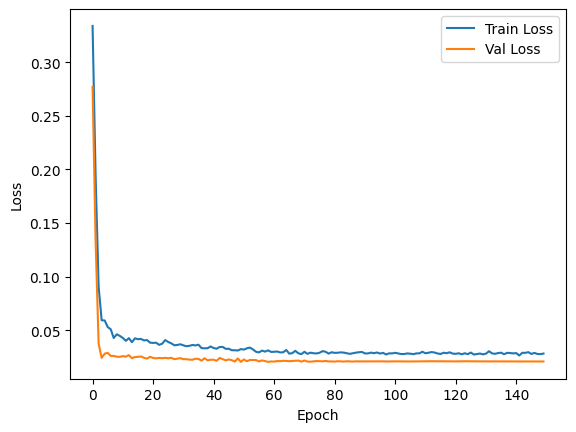

CNN with Frequency Input R²: 0.204


In [ ]:
traindataset_with_freq = WaveformDatasetWithFreq(train_set, data='wavei')
valdataset_with_freq = WaveformDatasetWithFreq(val_set, data='wavei')
testdataset_with_freq = WaveformDatasetWithFreq(test_set, data='wavei')

train_loader_with_freq = DataLoader(traindataset_with_freq, batch_size=64, shuffle=True)
val_loader_with_freq = DataLoader(valdataset_with_freq, batch_size=64, shuffle=False)
test_loader_with_freq = DataLoader(testdataset_with_freq, batch_size=64, shuffle=False)

model_with_freq, train_losses_with_freq, val_losses_with_freq = train_cnn_model_with_freq(
    train_loader_with_freq, 
    val_loader_with_freq, 
    num_epochs=150
)

plt.plot(train_losses_with_freq, label='Train Loss' )
plt.plot(val_losses_with_freq, label='Val Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on test set
model_with_freq.eval()
preds_with_freq = []
targets_with_freq = []
with torch.no_grad():
    for waveform, target, frequency, strain in test_loader_with_freq:
        if torch.backends.mps.is_available():
            device = torch.device('mps')
        elif torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')
        waveform, target, frequency, strain = waveform.to(device), target.to(device), frequency.to(device).unsqueeze(1), strain.to(device).unsqueeze(1)
        output = model_with_freq(waveform, frequency, strain)
        preds_with_freq.extend(output.squeeze().cpu().numpy()*20)
        targets_with_freq.extend(target.cpu().numpy()*20)

r2_with_freq = r2_score(targets_with_freq, preds_with_freq)
print(f'CNN with Frequency Input R²: {r2_with_freq:.3f}')

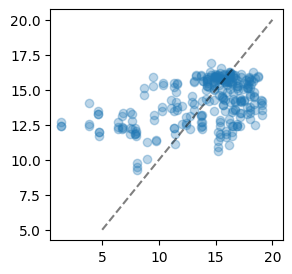

In [8]:
plt.figure(figsize=(3,3))
plt.plot([i for i in targets_with_freq], [i for i in preds_with_freq],'o', alpha=0.3)
plt.plot([5,20],[5,20],'k--', alpha=0.5)


### Feature Prediction

Using device: mps
Epoch 0/50, Train Loss: 166.1578 (Syn: 164.1101, Amp: 2.0477), Val Loss: 15.9739, Best Val Loss: inf
Epoch 5/50, Train Loss: 21.3913 (Syn: 20.1196, Amp: 1.2717), Val Loss: 11.2384, Best Val Loss: 11.5643
Epoch 10/50, Train Loss: 20.6128 (Syn: 19.9751, Amp: 0.6377), Val Loss: 12.4828, Best Val Loss: 11.2384
Epoch 15/50, Train Loss: 21.0629 (Syn: 20.5371, Amp: 0.5257), Val Loss: 16.0320, Best Val Loss: 10.9482
Epoch 20/50, Train Loss: 19.0766 (Syn: 18.5604, Amp: 0.5162), Val Loss: 10.6845, Best Val Loss: 10.7453
Epoch 25/50, Train Loss: 20.2634 (Syn: 19.7400, Amp: 0.5233), Val Loss: 12.0869, Best Val Loss: 10.6845
Epoch 30/50, Train Loss: 20.1224 (Syn: 19.6121, Amp: 0.5103), Val Loss: 11.3272, Best Val Loss: 10.6845
Epoch 35/50, Train Loss: 18.2945 (Syn: 17.7859, Amp: 0.5087), Val Loss: 11.4698, Best Val Loss: 10.6845
Epoch 40/50, Train Loss: 18.2801 (Syn: 17.7735, Amp: 0.5067), Val Loss: 11.0052, Best Val Loss: 10.6845
Early stopping at epoch 40


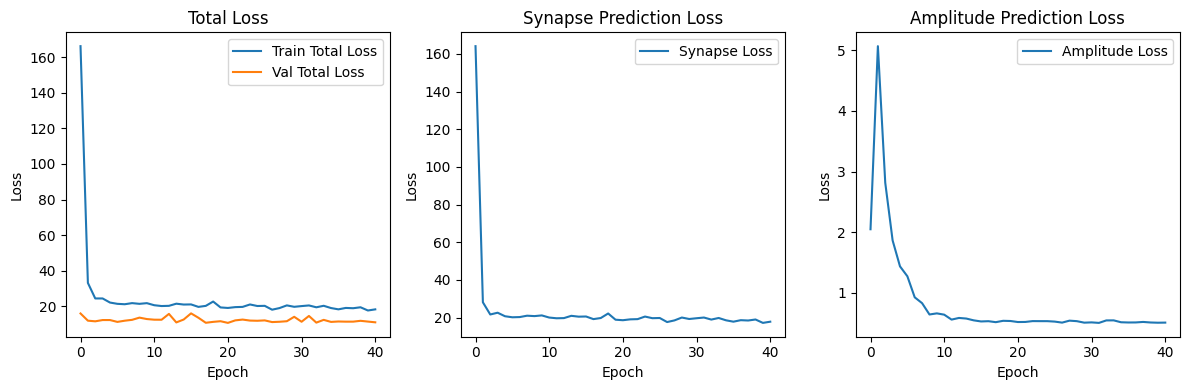

In [9]:
train_dataset = WaveformDataset(train_set, augment=True, augment_prob=0.7, feature_pred=True)
val_dataset = WaveformDataset(val_set, augment=False, feature_pred=True)
test_dataset = WaveformDataset(test_set, augment=False, feature_pred=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

feature_model, train_losses, val_losses, syn_losses, amp_losses = train_cnn_model(
    train_loader, val_loader, num_epochs=50, model_type='feature_pred', #early_stop=False
)

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Total Loss')
plt.plot(val_losses, label='Val Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Total Loss')

plt.subplot(1, 3, 2)
plt.plot(syn_losses, label='Synapse Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Synapse Prediction Loss')

plt.subplot(1, 3, 3)
plt.plot(amp_losses, label='Amplitude Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Amplitude Prediction Loss')

plt.tight_layout()
plt.show()

In [10]:
feature_model.eval()
    
synapse_predictions = []
amp_predictions = []

with torch.no_grad():
    for waveform, synapse_target, amplitude_target in test_loader:
        synapse_pred, amplitude_pred = feature_model(waveform)
        
        synapse_predictions.extend(synapse_pred.squeeze().numpy())
        amp_predictions.extend(amplitude_pred.squeeze().numpy())

# Convert to numpy arrays
synapse_predictions = np.array(synapse_predictions)
amp_predictions = np.array(amp_predictions)

test_results['Feature CNN Predictions'] = synapse_predictions
test_results['Feature CNN Amplitude Predictions'] = amp_predictions

# print r2:
r2_syn = r2_score(test_results['SynapsesPerIHC'], test_results['Feature CNN Predictions'])
r2_amp = r2_score(test_results['Amplitude'], test_results['Feature CNN Amplitude Predictions'])
print(f'Feature CNN Synapse R²: {r2_syn:.3f}')
print(f'Feature CNN Amplitude R²: {r2_amp:.3f}')

Feature CNN Synapse R²: 0.117
Feature CNN Amplitude R²: 0.117


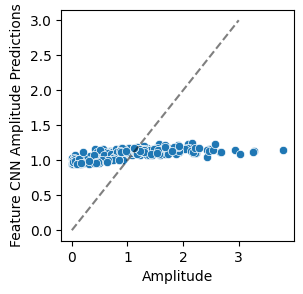

In [11]:
plt.figure(figsize=(3,3))
sns.scatterplot(test_results, x='Amplitude', y='Feature CNN Amplitude Predictions')
plt.plot([0, 3], [0,3], 'k--', alpha=0.5)

### Feature guided

In [12]:
train_dataset = WaveformDataset(train_set, augment=False, feature_pred=True)
val_dataset = WaveformDataset(val_set, augment=False, feature_pred=True)
test_dataset = WaveformDataset(test_set, augment=False, feature_pred=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Train the feature-guided model
feature_guided_model, train_losses, val_losses, syn_losses, amp_losses = train_cnn_model(
    train_loader, val_loader, num_epochs=100, model_type='feature_guided', early_stop=False
)

Using device: mps
Epoch 0/100, Train Loss: 220.7362 (Syn: 219.9929, Amp: 0.7433), Val Loss: 201.3043, Best Val Loss: inf
Epoch 10/100, Train Loss: 17.2914 (Syn: 16.2640, Amp: 1.0274), Val Loss: 10.0019, Best Val Loss: 10.0989
Epoch 20/100, Train Loss: 17.1820 (Syn: 16.5043, Amp: 0.6777), Val Loss: 9.8315, Best Val Loss: 9.8640
Epoch 30/100, Train Loss: 15.2637 (Syn: 14.7081, Amp: 0.5556), Val Loss: 10.0579, Best Val Loss: 9.4188
Epoch 40/100, Train Loss: 16.4297 (Syn: 15.9361, Amp: 0.4936), Val Loss: 8.6536, Best Val Loss: 8.5358
Epoch 50/100, Train Loss: 15.8961 (Syn: 15.4352, Amp: 0.4609), Val Loss: 8.6477, Best Val Loss: 8.4374
Epoch 60/100, Train Loss: 14.1578 (Syn: 13.6925, Amp: 0.4653), Val Loss: 8.2257, Best Val Loss: 8.4014
Epoch 70/100, Train Loss: 14.8343 (Syn: 14.3775, Amp: 0.4568), Val Loss: 8.6829, Best Val Loss: 8.2257
Epoch 80/100, Train Loss: 14.3010 (Syn: 13.8311, Amp: 0.4698), Val Loss: 9.0392, Best Val Loss: 8.2257
Epoch 90/100, Train Loss: 14.0624 (Syn: 13.6104, Amp

In [13]:

# Evaluate
feature_guided_model.eval()
synapse_predictions = []
amp_predictions = []

with torch.no_grad():
    for waveform, synapse_target, amplitude_target in test_loader:
        synapse_pred, amplitude_pred = feature_guided_model(waveform)
        synapse_predictions.extend(synapse_pred.squeeze().numpy())
        amp_predictions.extend(amplitude_pred.squeeze().numpy())

synapse_predictions = np.array(synapse_predictions)
amp_predictions = np.array(amp_predictions)

r2_syn = r2_score(test_results['SynapsesPerIHC'], synapse_predictions)
r2_amp = r2_score(test_results['Amplitude'], amp_predictions)
test_results['Feature-guided CNN Predictions'] = synapse_predictions
print(f'Feature-Guided CNN Synapse R²: {r2_syn:.3f}')
print(f'Feature-Guided CNN Amplitude R²: {r2_amp:.3f}')


Feature-Guided CNN Synapse R²: 0.270
Feature-Guided CNN Amplitude R²: 0.254



Training WaveI CNN model... wavei
Using device: mps
Epoch 0/200, Train Loss: 235.2131, Val Loss: 240.0606, Best Val Loss: inf
Epoch 20/200, Train Loss: 26.9021, Val Loss: 19.3278, Best Val Loss: 20.7687
Epoch 40/200, Train Loss: 21.5697, Val Loss: 11.6689, Best Val Loss: 11.2579
Epoch 60/200, Train Loss: 21.1359, Val Loss: 10.9773, Best Val Loss: 10.3159
Early stopping at epoch 78


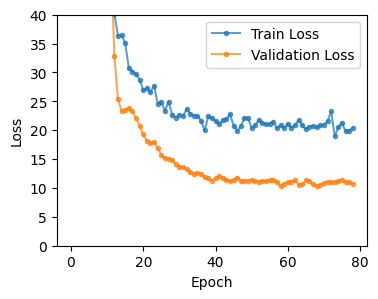

Test Set RMSE: 3.5286
Test Set R²: 0.1761

Training WaveI CNN2 model... minimal_wavei
Using device: mps
Epoch 0/200, Train Loss: 234.9000, Val Loss: 240.1286, Best Val Loss: inf
Epoch 20/200, Train Loss: 220.6076, Val Loss: 225.6469, Best Val Loss: 226.6411
Epoch 40/200, Train Loss: 186.4585, Val Loss: 192.1403, Best Val Loss: 194.6489
Epoch 60/200, Train Loss: 111.8073, Val Loss: 121.0660, Best Val Loss: 125.1752
Epoch 80/200, Train Loss: 41.6534, Val Loss: 51.5175, Best Val Loss: 53.9861
Epoch 100/200, Train Loss: 20.4657, Val Loss: 25.6397, Best Val Loss: 26.1918
Epoch 120/200, Train Loss: 16.9990, Val Loss: 19.9230, Best Val Loss: 20.0723
Epoch 140/200, Train Loss: 15.2847, Val Loss: 17.3268, Best Val Loss: 17.4067
Epoch 160/200, Train Loss: 13.9283, Val Loss: 15.5525, Best Val Loss: 15.6156
Epoch 180/200, Train Loss: 13.2666, Val Loss: 14.2910, Best Val Loss: 14.3483


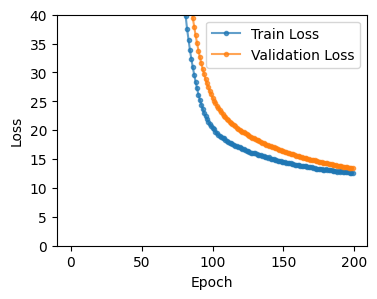

Test Set RMSE: 3.9389
Test Set R²: -0.0266

Training CNN model... default
Using device: mps
Epoch 0/100, Train Loss: 136.8165, Val Loss: 33.4285, Best Val Loss: inf
Epoch 10/100, Train Loss: 9.5183, Val Loss: 9.5438, Best Val Loss: 8.8707
Epoch 20/100, Train Loss: 9.0938, Val Loss: 8.5628, Best Val Loss: 8.1893
Epoch 30/100, Train Loss: 8.2345, Val Loss: 8.7102, Best Val Loss: 7.9757
Epoch 40/100, Train Loss: 8.5722, Val Loss: 8.8406, Best Val Loss: 7.9757
Early stopping at epoch 44


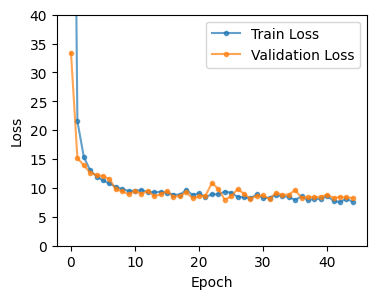

Test Set RMSE: 3.4216
Test Set R²: 0.2254

Training CNN2 model... improved
Using device: mps
Epoch 0/100, Train Loss: 171.9981, Val Loss: 18.6102, Best Val Loss: inf
Epoch 10/100, Train Loss: 18.3226, Val Loss: 11.1609, Best Val Loss: 10.7090
Epoch 20/100, Train Loss: 18.0749, Val Loss: 11.4260, Best Val Loss: 10.7090
Early stopping at epoch 28


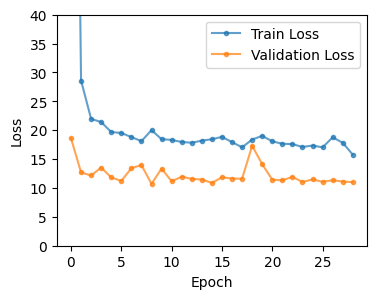

Test Set RMSE: 3.6348
Test Set R²: 0.1258


In [14]:
for name, model in zip(['WaveI CNN', 'WaveI CNN2', 'CNN', 'CNN2'], 
                         ['wavei', 'minimal_wavei', 'default', 'improved']):
    print(f'\nTraining {name} model... {model}')
    if 'wavei' in model:
        data = 'wavei'
        augment_prob = 0.3
        epochs = 200
    else:
        data = 'waveform'
        augment_prob = 0.7
        epochs = 100
    train_dataset = WaveformDataset(train_set, data=data, augment=True, augment_prob=augment_prob)
    val_dataset = WaveformDataset(val_set, data=data, augment=False)
    test_dataset = WaveformDataset(test_set, data=data, augment=False)

    if 'wavei' in model:
        batch_size = 64*2
    else:
        batch_size = 32

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Train the model
    trained_model, train_losses, val_losses = train_cnn_model(train_loader, val_loader, model_type=model, num_epochs=epochs)

    plt.figure(figsize=(4,3))
    plt.plot(train_losses, 'o-', label='Train Loss', markersize=3, alpha=0.7)
    plt.plot(val_losses, 'o-', label='Validation Loss', markersize=3, alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 40])
    plt.legend()
    plt.show()


    # Make predictions on test set
    trained_model.eval()
    test_predictions = []
    test_actuals = []

    with torch.no_grad():
        for data, target in test_loader:
            output = trained_model(data)
            test_predictions.extend(output.squeeze().numpy())
            test_actuals.extend(target.numpy())

    # Convert to numpy arrays
    test_predictions = np.array(test_predictions)
    test_actuals = np.array(test_actuals)

    # Calculate metrics
    test_rmse = np.sqrt(np.mean((test_actuals - test_predictions)**2))
    ss_res = np.sum((test_actuals - test_predictions) ** 2)
    ss_tot = np.sum((test_actuals - np.mean(test_actuals)) ** 2)
    test_r2 = 1 - (ss_res / ss_tot)

    print(f'Test Set RMSE: {test_rmse:.4f}')
    print(f'Test Set R²: {test_r2:.4f}')

    test_results[name+' Predictions'] = test_predictions
    

In [15]:
preds_by_mouse_freq = test_results.groupby(['Subject', 'Frequency(kHz)']).agg(
    {'WaveI CNN Predictions': 'mean',
     'WaveI CNN2 Predictions': 'mean',
     'CNN2 Predictions': 'mean',
     'CNN Predictions': 'mean',
     'Feature-guided CNN Predictions': 'mean',
    #  'CNN Aug Predictions': 'mean',
     'SynapsesPerIHC': 'mean', 
     'Amplitude': 'mean',
     'Group': 'first', 
     'Noise': 'mean'}).reset_index()
preds_by_mouse_freq.head()


,Subject,Frequency(kHz),WaveI CNN Predictions,WaveI CNN2 Predictions,CNN2 Predictions,CNN Predictions,Feature-guided CNN Predictions,SynapsesPerIHC,Amplitude,Group,Noise
0,WPZ101,32.0,15.585657,14.323296,15.147220,14.585903,15.229557,16.193497,1.825701,8wks ctrl,0.00
1,WPZ101,45.2,12.715668,13.112756,13.717132,11.604522,13.673623,15.351421,0.212616,8wks ctrl,0.00
2,WPZ104,8.0,13.811760,17.210979,14.911726,13.672075,14.359099,14.131579,1.063704,98dB 2w post,0.98
3,WPZ104,11.3,14.434379,16.867382,14.873713,14.608554,15.345243,15.585692,1.484396,98dB 2w post,0.98
4,WPZ104,16.0,14.365667,17.172894,15.118829,15.163385,14.682215,14.879167,1.541101,98dB 2w post,0.98


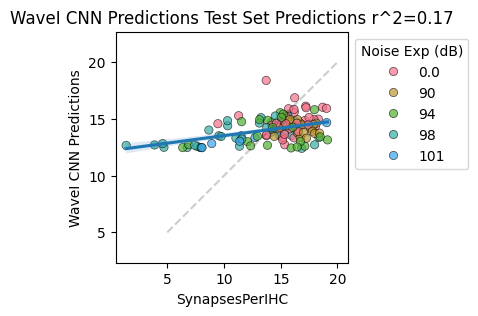

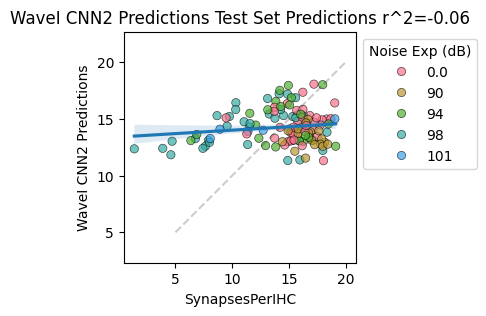

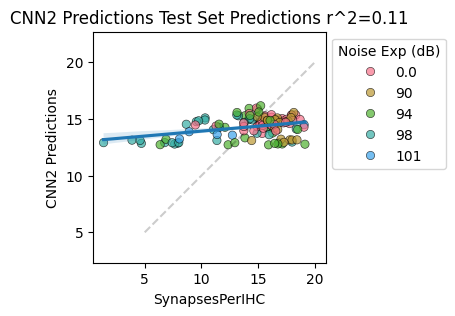

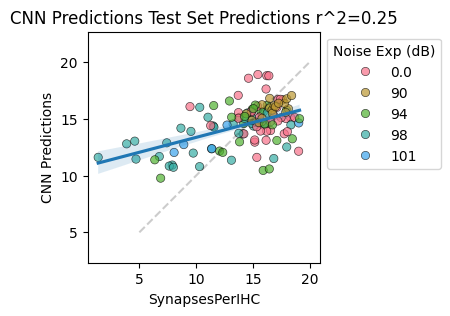

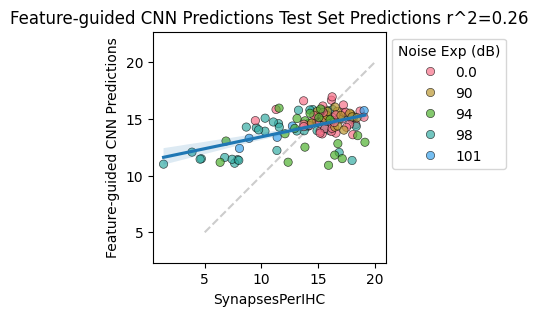

In [16]:
def reformat_legend(legend):
    new_labels = [f'{int(float(label.get_text())*100)}' for label in legend.texts[1:]]
    for t, l in zip(plt.gca().get_legend().texts[1:], new_labels):
        t.set_text(l)

predicted_columns = [x for x in preds_by_mouse_freq.columns if 'Predictions' in x]
for pred in predicted_columns:

    plt.figure(figsize=(3,3))
    plt.plot([5,20],[5,20],'k--', alpha=0.2)
    sns.scatterplot(preds_by_mouse_freq, x='SynapsesPerIHC', y=pred, hue='Noise', palette=sns.color_palette("husl", 6), alpha=0.7, edgecolor='black')
    plt.xlabel('GT Synapses/IHC')
    plt.ylabel('Predicted Synapses/IHC')
    plt.legend(title='Noise Exp (dB)', loc='upper left', bbox_to_anchor=(1, 1))
    reformat_legend(plt.gca().get_legend())
    # add best fit line:
    sns.regplot(preds_by_mouse_freq, x='SynapsesPerIHC', y=pred, scatter=False)
    plt.xlim([0, 30])
    plt.ylim([0, 30])
    plt.axis('equal')
    r2 = r2_score(preds_by_mouse_freq['SynapsesPerIHC'], preds_by_mouse_freq[pred])
    plt.title(f'{pred} Test Set Predictions r^2={r2:.2f}')
    plt.show()
    

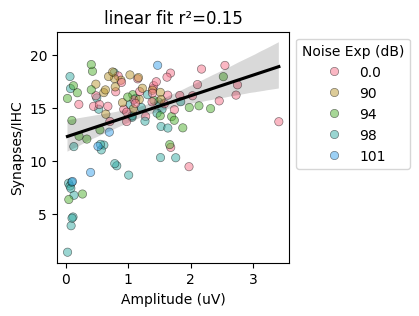

In [17]:
plt.figure(figsize=(3,3))
sns.scatterplot(preds_by_mouse_freq, x='Amplitude', y='SynapsesPerIHC', hue='Noise', palette=sns.color_palette("husl", 6), alpha=0.5, edgecolor='black')
# plot best fit line:
sns.regplot(preds_by_mouse_freq, x='Amplitude', y='SynapsesPerIHC', scatter=False, color='black')
#r2 of best fit line:
linear_fit = np.polyfit(preds_by_mouse_freq['Amplitude'], preds_by_mouse_freq['SynapsesPerIHC'], 1)
r2 = r2_score(preds_by_mouse_freq['SynapsesPerIHC'], np.polyval(linear_fit, preds_by_mouse_freq['Amplitude']))
plt.xlabel('Amplitude (uV)')
plt.ylabel('Synapses/IHC')
plt.title('linear fit r²={:.2f}'.format(r2))
plt.legend(title='Noise Exp (dB)', loc='upper left', bbox_to_anchor=(1, 1))
reformat_legend(plt.gca().get_legend())
plt.show()


In [18]:
class WaveformDatasetWithFreq(Dataset):
    def __init__(self, df, data='waveform'):
        self.df = df
        self.data = data
        self.waveforms, self.targets, self.frequencies = self.prepare_data(df)
    
    def prepare_data(self, df):
        waveforms = []
        targets = []
        frequencies = []
        
        for idx, row in df.iterrows():
            if self.data == 'waveform':
                orig_y = row['Waveform']
                waveform = self.preprocess_waveform(orig_y, 20)
            elif self.data == 'wavei':
                waveform = row['WaveI']
            
            waveforms.append(waveform)
            targets.append(row['SynapsesPerIHC']/20)
            frequencies.append(row['Frequency(kHz)']/45.2)
        
        return waveforms, targets, frequencies
    
    def preprocess_waveform(self, waveform, time_scale):
        orig_y = waveform
        tenms = int((10/time_scale)*len(orig_y)) if time_scale > 10 else len(orig_y)
        return interpolate_and_smooth(orig_y[:tenms], 244)

    def __len__(self):
        return len(self.waveforms)
    
    def __getitem__(self, idx):
        waveform = self.waveforms[idx].copy()
        
        waveform_tensor = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0)
        target_tensor = torch.tensor(self.targets[idx], dtype=torch.float32)
        frequency_tensor = torch.tensor(self.frequencies[idx], dtype=torch.float32)
        return waveform_tensor, target_tensor, frequency_tensor

class WaveICNNWithFrequency(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(WaveICNNWithFrequency, self).__init__()

        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)  # 30 -> 30
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)  # 30 -> 30
        
        self.pool = nn.MaxPool1d(2)  # 30 -> 15 -> 7 (with padding)
        
        self.dropout = nn.Dropout(dropout_rate)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        self.fc = nn.Sequential(
            nn.Linear(33, 16), #32 pooled features + 1 frequency
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(16, 1)
        )
        
    def forward(self, x, frequency):
        x = F.relu(self.conv1(x))
        x = self.pool(x)  # (batch_size, 16, 15)
    
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # (batch_size, 32, 7)
        
        x = self.dropout(x)
        
        # Global pooling
        x = self.global_pool(x).squeeze(-1)  # (batch_size, 32)
        x = torch.cat([x, frequency], dim=1)  # (batch_size, 33)
        
        # Fully connected layers
        x = self.fc(x)
        return x    

def train_cnn_model_with_freq(train_loader, val_loader, num_epochs=100, 
                    ):
    if torch.backends.mps.is_available():
        device = torch.device('mps')
    elif torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    print(f"Using device: {device}")

    model = WaveICNNWithFrequency(dropout_rate=0.3)
    model.to(device)

    # Loss function and optimizer
    criterion = nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    # Training loop
    train_losses = []
    val_losses = []
    
    print_every = num_epochs // 10 if num_epochs >= 10 else 1
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_idx, data in enumerate(train_loader):
            optimizer.zero_grad()
            waveform, target, frequency = data
            waveform, target, frequency = waveform.to(device), target.to(device), frequency.to(device).unsqueeze(1)

            output = model(waveform, frequency)
            loss = criterion(output.squeeze(), target)
            
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()
            
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for waveform, target, frequency in val_loader:
                waveform, target, frequency = waveform.to(device), target.to(device), frequency.to(device).unsqueeze(1)
                output = model(waveform, frequency)
                loss = criterion(output.squeeze(), target)
                val_loss += loss.item()

        # Calculate average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        scheduler.step(avg_val_loss)
        
        # print progress
        if epoch % print_every == 0:
            print(f'Epoch {epoch}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return model, train_losses, val_losses

Using device: mps
Epoch 0/150, Train Loss: 0.2938, Val Loss: 0.2285
Epoch 15/150, Train Loss: 0.0437, Val Loss: 0.0265
Epoch 30/150, Train Loss: 0.0419, Val Loss: 0.0247
Epoch 45/150, Train Loss: 0.0350, Val Loss: 0.0249
Epoch 60/150, Train Loss: 0.0358, Val Loss: 0.0238
Epoch 75/150, Train Loss: 0.0314, Val Loss: 0.0225
Epoch 90/150, Train Loss: 0.0303, Val Loss: 0.0229
Epoch 105/150, Train Loss: 0.0283, Val Loss: 0.0230
Epoch 120/150, Train Loss: 0.0289, Val Loss: 0.0226
Epoch 135/150, Train Loss: 0.0291, Val Loss: 0.0226


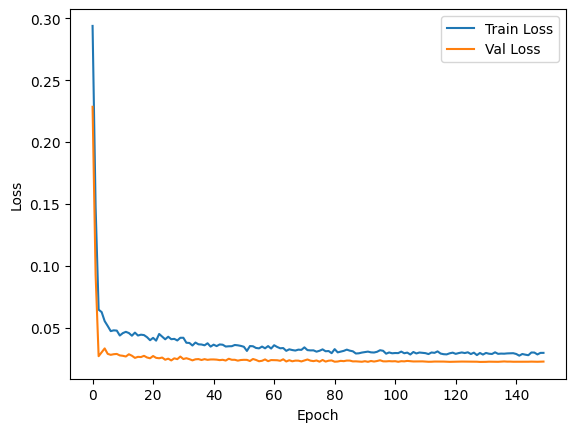

CNN with Frequency Input R²: 0.250


In [19]:
traindataset_with_freq = WaveformDatasetWithFreq(train_set, data='wavei')
valdataset_with_freq = WaveformDatasetWithFreq(val_set, data='wavei')
testdataset_with_freq = WaveformDatasetWithFreq(test_set, data='wavei')

train_loader_with_freq = DataLoader(traindataset_with_freq, batch_size=64, shuffle=True)
val_loader_with_freq = DataLoader(valdataset_with_freq, batch_size=64, shuffle=False)
test_loader_with_freq = DataLoader(testdataset_with_freq, batch_size=64, shuffle=False)

model_with_freq, train_losses_with_freq, val_losses_with_freq = train_cnn_model_with_freq(
    train_loader_with_freq, 
    val_loader_with_freq, 
    num_epochs=150
)

plt.plot(train_losses_with_freq, label='Train Loss' )
plt.plot(val_losses_with_freq, label='Val Loss')
#plt.ylim([0,100])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Evaluate on test set
model_with_freq.eval()
preds_with_freq = []
targets_with_freq = []
with torch.no_grad():
    for waveform, target, frequency in test_loader_with_freq:
        if torch.backends.mps.is_available():
            device = torch.device('mps')
        elif torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')
        waveform, target, frequency = waveform.to(device), target.to(device), frequency.to(device).unsqueeze(1)
        output = model_with_freq(waveform, frequency)
        preds_with_freq.extend(output.squeeze().cpu().numpy())
        targets_with_freq.extend(target.cpu().numpy())

r2_with_freq = r2_score(targets_with_freq, preds_with_freq)
print(f'CNN with Frequency Input R²: {r2_with_freq:.3f}')

Using device: mps
Epoch 0/150, Train Loss: 0.2471, Val Loss: 0.2171
Epoch 15/150, Train Loss: 0.0405, Val Loss: 0.0255
Epoch 30/150, Train Loss: 0.0366, Val Loss: 0.0247
Epoch 45/150, Train Loss: 0.0366, Val Loss: 0.0238
Epoch 60/150, Train Loss: 0.0338, Val Loss: 0.0243
Epoch 75/150, Train Loss: 0.0323, Val Loss: 0.0241
Epoch 90/150, Train Loss: 0.0323, Val Loss: 0.0231
Epoch 105/150, Train Loss: 0.0315, Val Loss: 0.0231
Epoch 120/150, Train Loss: 0.0299, Val Loss: 0.0231
Epoch 135/150, Train Loss: 0.0311, Val Loss: 0.0232


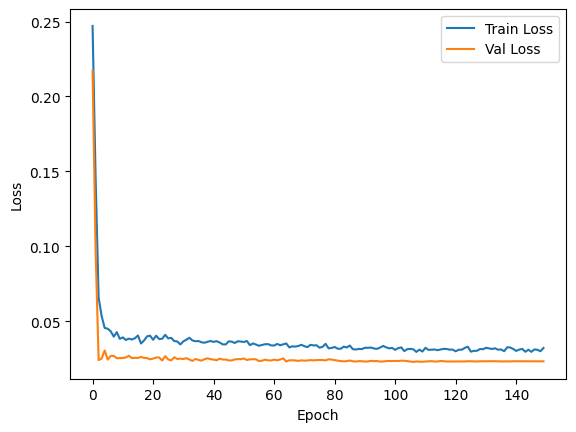

CNN with Frequency Input R²: 0.209


In [20]:
class WaveDataset(Dataset):
    def __init__(self, df, data='waveform'):
        self.df = df
        self.data = data
        self.waveforms, self.targets = self.prepare_data(df)
    
    def prepare_data(self, df):
        waveforms = []
        targets = []
        
        for idx, row in df.iterrows():
            if self.data == 'waveform':
                orig_y = row['Waveform']
                waveform = self.preprocess_waveform(orig_y, 20)
            elif self.data == 'wavei':
                waveform = row['WaveI']
            
            waveforms.append(waveform)
            targets.append(row['SynapsesPerIHC']/20)
        
        return waveforms, targets
    
    def preprocess_waveform(self, waveform, time_scale):
        orig_y = waveform
        tenms = int((10/time_scale)*len(orig_y)) if time_scale > 10 else len(orig_y)
        return interpolate_and_smooth(orig_y[:tenms], 244)

    def __len__(self):
        return len(self.waveforms)
    
    def __getitem__(self, idx):
        waveform = self.waveforms[idx].copy()
        
        waveform_tensor = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0)
        target_tensor = torch.tensor(self.targets[idx], dtype=torch.float32)
        return waveform_tensor, target_tensor

class WaveICNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(WaveICNN, self).__init__()

        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)  # 30 -> 30
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)  # 30 -> 30
        
        self.pool = nn.MaxPool1d(2)  # 30 -> 15 -> 7 (with padding)
        
        self.dropout = nn.Dropout(dropout_rate)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        self.fc = nn.Sequential(
            nn.Linear(32, 16), 
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(16, 1)
        )
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)  # (batch_size, 16, 15)
    
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # (batch_size, 32, 7)
        
        x = self.dropout(x)
        
        # Global pooling
        x = self.global_pool(x).squeeze(-1)  # (batch_size, 32)
        
        # Fully connected layers
        x = self.fc(x)
        return x    

def train_cnn_model_without_freq(train_loader, val_loader, num_epochs=100, 
                    ):
    if torch.backends.mps.is_available():
        device = torch.device('mps')
    elif torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    print(f"Using device: {device}")

    model = WaveICNN(dropout_rate=0.3)
    model.to(device)

    # Loss function and optimizer
    criterion = nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    # Training loop
    train_losses = []
    val_losses = []
    
    print_every = num_epochs // 10 if num_epochs >= 10 else 1
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_idx, data in enumerate(train_loader):
            optimizer.zero_grad()
            waveform, target = data
            waveform, target = waveform.to(device), target.to(device), 
            output = model(waveform)
            loss = criterion(output.squeeze(), target)
            
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()
            
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for waveform, target in val_loader:
                waveform, target = waveform.to(device), target.to(device), 
                output = model(waveform)
                loss = criterion(output.squeeze(), target)
                val_loss += loss.item()

        # Calculate average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        scheduler.step(avg_val_loss)
        
        # print progress
        if epoch % print_every == 0:
            print(f'Epoch {epoch}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return model, train_losses, val_losses

traindataset_with_freq = WaveDataset(train_set, data='wavei')
valdataset_with_freq = WaveDataset(val_set, data='wavei')
testdataset_with_freq = WaveDataset(test_set, data='wavei')

train_loader_with_freq = DataLoader(traindataset_with_freq, batch_size=64, shuffle=True)
val_loader_with_freq = DataLoader(valdataset_with_freq, batch_size=64, shuffle=False)
test_loader_with_freq = DataLoader(testdataset_with_freq, batch_size=64, shuffle=False)

model_with_freq, train_losses_with_freq, val_losses_with_freq = train_cnn_model_without_freq(
    train_loader_with_freq, 
    val_loader_with_freq, 
    num_epochs=150
)

plt.plot(train_losses_with_freq, label='Train Loss' )
plt.plot(val_losses_with_freq, label='Val Loss')
#plt.ylim([0,100])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Evaluate on test set
model_with_freq.eval()
preds_with_freq = []
targets_with_freq = []
with torch.no_grad():
    for waveform, target in test_loader_with_freq:
        if torch.backends.mps.is_available():
            device = torch.device('mps')
        elif torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')
        waveform, target = waveform.to(device), target.to(device)
        output = model_with_freq(waveform)
        preds_with_freq.extend(output.squeeze().cpu().numpy())
        targets_with_freq.extend(target.cpu().numpy())

r2_with_freq = r2_score(targets_with_freq, preds_with_freq)
print(f'CNN with Frequency Input R²: {r2_with_freq:.3f}')

Text(0, 0.5, 'Predicted Synapses/IHC')

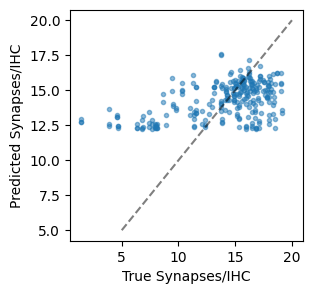

In [21]:
plt.figure(figsize=(3,3))
plt.plot([i*20 for i in targets_with_freq], [i*20 for i in preds_with_freq], '.', alpha=0.5)
plt.plot([5, 20], [5, 20], 'k--', alpha=0.5)
plt.xlabel('True Synapses/IHC')
plt.ylabel('Predicted Synapses/IHC')
